In [1]:
import numpy as np
from scipy import interpolate, optimize
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200

In [2]:
import sim_steady_state_fast as sim

# Calibrating an Aiyagari model
In the national accounts, the US capital-output ratio $K/Y$ is about 250%. Let's further calibrate $\delta=5\%$ and $r=5\%$, all annual.

We can compute the implied capital share of income $(r+\delta)K/Y=25\%$ directly from this, and then the labor share $wL/Y = 1-(r+\delta)K/Y = 75\%$. Finally, we obtain the ratio of capital to labor income $K/wL = 250\%/75\% = 3.33$.

Our actual calibration will be quarterly. We'll normalize both $w$ and $L$ to 1.

In [3]:
# remember to annualize everything
K_Y = 2.5 * 4
r = 0.05 / 4
delta = 0.05 / 4

In [4]:
alpha = (r+delta)*K_Y
alpha

0.25

In [5]:
k_w = K_Y / (1-alpha)
k_w

13.333333333333334

With the normalizations $w=1$ amd $L=1$, this is just $K$:

In [6]:
K = k_w

Now load our example calibration and set $r$ to the right level. Since $w$ is normalized to 1, our $y(s)$ (which we compute to have an average of 1) are equal to $e(s)$, whose aggregate $L$ we also normalize to 1.

In [7]:
calib = sim.example_calibration()
calib['r'] = r

We want total assets to hit $K$, and will search for the $\beta$ that obtains this, using Brent's method with a range from a low value, $\beta=0.9$, to something a bit below $1/(1+r)$:

In [8]:
beta = optimize.brentq(lambda beta: sim.steady_state(**{**calib, 'beta': beta})['A'] - K,
                          0.9, 0.995/(1+r))

Look at resulting $\beta$ and compare to $1/(1+r)$:

In [9]:
beta, 1/(1+r)

(0.9822100159135264, 0.9876543209876544)

Get full steady state and now we're in business:

In [10]:
calib['beta'] = beta
ss = sim.steady_state(**calib)

# Obtaining $a(r)$ and $k(r)/w(r)$ curves
We can obtain $a(r)$, which is aggregate asset demand normalized by aggregate wage income (which we've normalized to 1), just by plotting out steady-state $A$ for different $r$. In fact, it's something we've already done.

For $k(r)/w(r)$, we need additional assumptions on production. Given Cobb-Douglas, in the slides we have

$$
\frac{k(r)}{w(r)} = \frac{\alpha}{1-\alpha}\frac{1}{r+\delta}
$$

which we can write as a function:

In [11]:
def k_w_r(r):
    return alpha/(1-alpha)/(r+delta)

Now let's find $r$s around our benchmark $r$ and evaluate at them. To avoid using too many points, and also to get an easily-evaluated derivative for free, we'll fit a cubic spline between the points:

In [12]:
rs = r + np.linspace(-0.0025, 0.0025, 8)
As = np.array([sim.steady_state(**{**calib, 'r': r})['A'] for r in rs])
a_r = interpolate.CubicSpline(rs, As)

In [13]:
rs_dense = r + np.linspace(-0.0025, 0.0025, 100)
as_dense = a_r(rs_dense)
kws_dense = k_w_r(rs_dense)

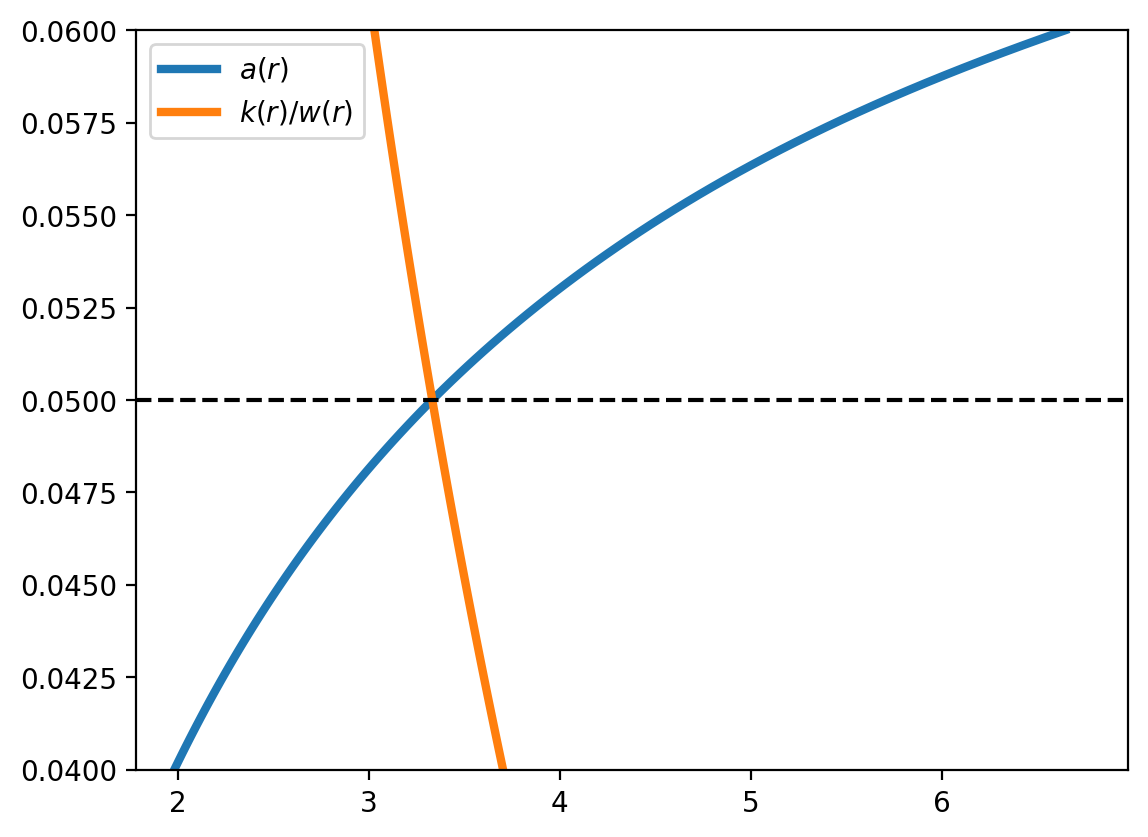

In [14]:
plt.plot(as_dense/4, 4*rs_dense, label=r'$a(r)$', linewidth=3)
plt.plot(kws_dense/4, 4*rs_dense, label=r'$k(r)/w(r)$', linewidth=3)
plt.legend()
plt.ylim(4*rs[0], 4*rs[-1])
plt.xlim(As[0]*0.9/4, As[-1]*1.05/4)
plt.axhline(4*r, color='black', linestyle='dashed');

What are the local log-slopes of these curves with respect to $r$? Much more elastic in demand than supply:

In [15]:
eps_d_r = a_r.derivative()(r)/a_r(r)
eps_s_r = -(k_w_r(r+1E-4) - k_w_r(r-1E-4))/2E-4/K

In [16]:
eps_d_r, eps_s_r

(231.5355214308986, 40.00064001023973)

# Shock: income inequality
Reevaluate steady state with new level of income inequality, which we interpret as a spread of $\log e(s)$ that preserves the mean of 1.

Want to solve for equilibrium $r$, which we could do directly, but we're going to get the new curve anyway.

Here we'll use the same persistence and sd parameters used in `sim` to calibrate $y$, except that we add 0.04 to the latter.

In [17]:
y_new = sim.discretize_income(0.975, 0.7+0.12, len(ss['y']))[0]

In [18]:
As_new = np.array([sim.steady_state(**{**calib, 'y':y_new, 'r': r})['A'] for r in rs])
a_r_new = interpolate.CubicSpline(rs, As_new)
as_dense_new = a_r_new(rs_dense)

What's our new intersection? Looks like annual $r$ falls by about 0.6%.

In [19]:
rnew = optimize.brentq(lambda r: a_r_new(r) - k_w_r(r), r-0.01, r+0.01)
4*rnew, 4*r

(0.044288058668960614, 0.05)

Let's test to make sure that this is indeed an equilibrium, using the actual steady-state function (this is effectively a test of our cubic spline interpolation).

In [20]:
ss_new = sim.steady_state(**{**calib, 'y':y_new, 'r': rnew})
(ss_new['A'] - k_w_r(rnew))/ss_new['A']

2.4230089365385643e-05

It's pretty good but not totally exact, with a relative error in the 5th decimal place. (Good enough that we won't worry about it!)

Let's repeat the plot with this shift in curve:

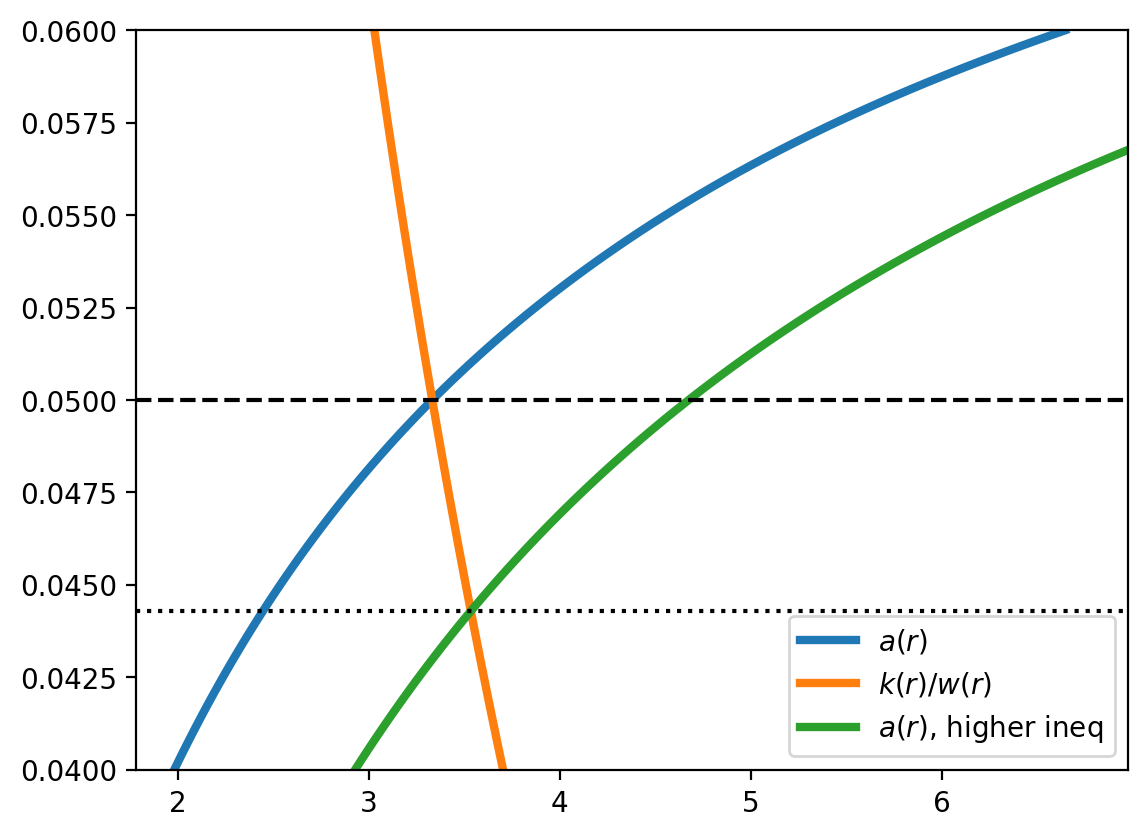

In [21]:
plt.plot(as_dense/4, 4*rs_dense, label=r'$a(r)$', linewidth=3)
plt.plot(kws_dense/4, 4*rs_dense, label=r'$k(r)/w(r)$', linewidth=3)
plt.plot(as_dense_new/4, 4*rs_dense, label=r'$a(r)$, higher ineq', linewidth=3)
plt.legend()
plt.ylim(4*rs[0], 4*rs[-1])
plt.xlim(As[0]*0.9/4, As[-1]*1.05/4)
plt.axhline(4*r, color='black', linestyle='dashed');
plt.axhline(4*rnew, color='black', linestyle='dotted');

How big was partial equilibrium increase in asset demand?

In [22]:
(a_r_new(r) - a_r(r))/a_r(r)

0.40270101563471217

What about GE?

In [23]:
(a_r_new(rnew) - a_r(r))/a_r(r)

0.06062046636298761

Ratio:

In [24]:
(a_r_new(rnew) - a_r(r))/(a_r_new(r) - a_r(r))

0.15053467463309328

Or ratio in logs, a bit higher:

In [25]:
(np.log(a_r_new(rnew)) - np.log(a_r(r)))/(np.log(a_r_new(r)) - np.log(a_r(r)))

0.17391885064977566

How does this compare to our semielasticity formula?

In [26]:
eps_s_r/(eps_d_r + eps_s_r) 

0.1473123866741807

Now let's implement formula for change in r:

In [27]:
pe_shock = np.log(a_r_new(r)) - np.log(a_r(r))
pe_shock

0.3383996748001965

In [28]:
eps_d_r/4

57.88388035772465

In [29]:
eps_s_r/4

10.000160002559932

Formula prediction:

In [30]:
pe_shock / (eps_d_r + eps_s_r) * 4

0.004984966613716418

Actual change is larger because of curvature, semielasticity of demand getting smaller with lower r:

In [31]:
(rnew - r)*4

-0.0057119413310393885